In [18]:
import numpy as np
import pandas as pd

In [ ]:
basics_url = 'https://datasets.imdbws.com/title.basics.tsv.gz'
ratings_url = 'https://datasets.imdbws.com/title.ratings.tsv.gz'

basics_df = pd.read_csv(basics_url, sep='\t', compression='gzip')
ratings_df = pd.read_csv(ratings_url, sep='\t', compression='gzip')

merged_df = pd.merge(basics_df, ratings_df, on='tconst', how='left')

In [ ]:
movies_df = merged_df[merged_df['titleType'] == 'movie']

movies_df['startYear'] = pd.to_numeric(movies_df['startYear'].replace(r'\\N', pd.NA), errors='coerce')
movies_df = movies_df[movies_df['startYear'] >= 2000]

movies_df['runtimeMinutes'] = pd.to_numeric(movies_df['runtimeMinutes'].replace(r'\\N', pd.NA), errors='coerce')
movies_df = movies_df[(movies_df['runtimeMinutes'] >= 90) & (movies_df['runtimeMinutes'] <= 210)]

movies_df = movies_df[~movies_df['genres'].str.contains('Documentary', na=False)]

movies_df = movies_df[movies_df['averageRating'] >= 5]

movies_df = movies_df[movies_df['numVotes'] >= 10000]

movies_df = movies_df.drop(columns=['endYear', 'primaryTitle', 'isAdult', 'titleType'])

movies_df = movies_df.dropna()

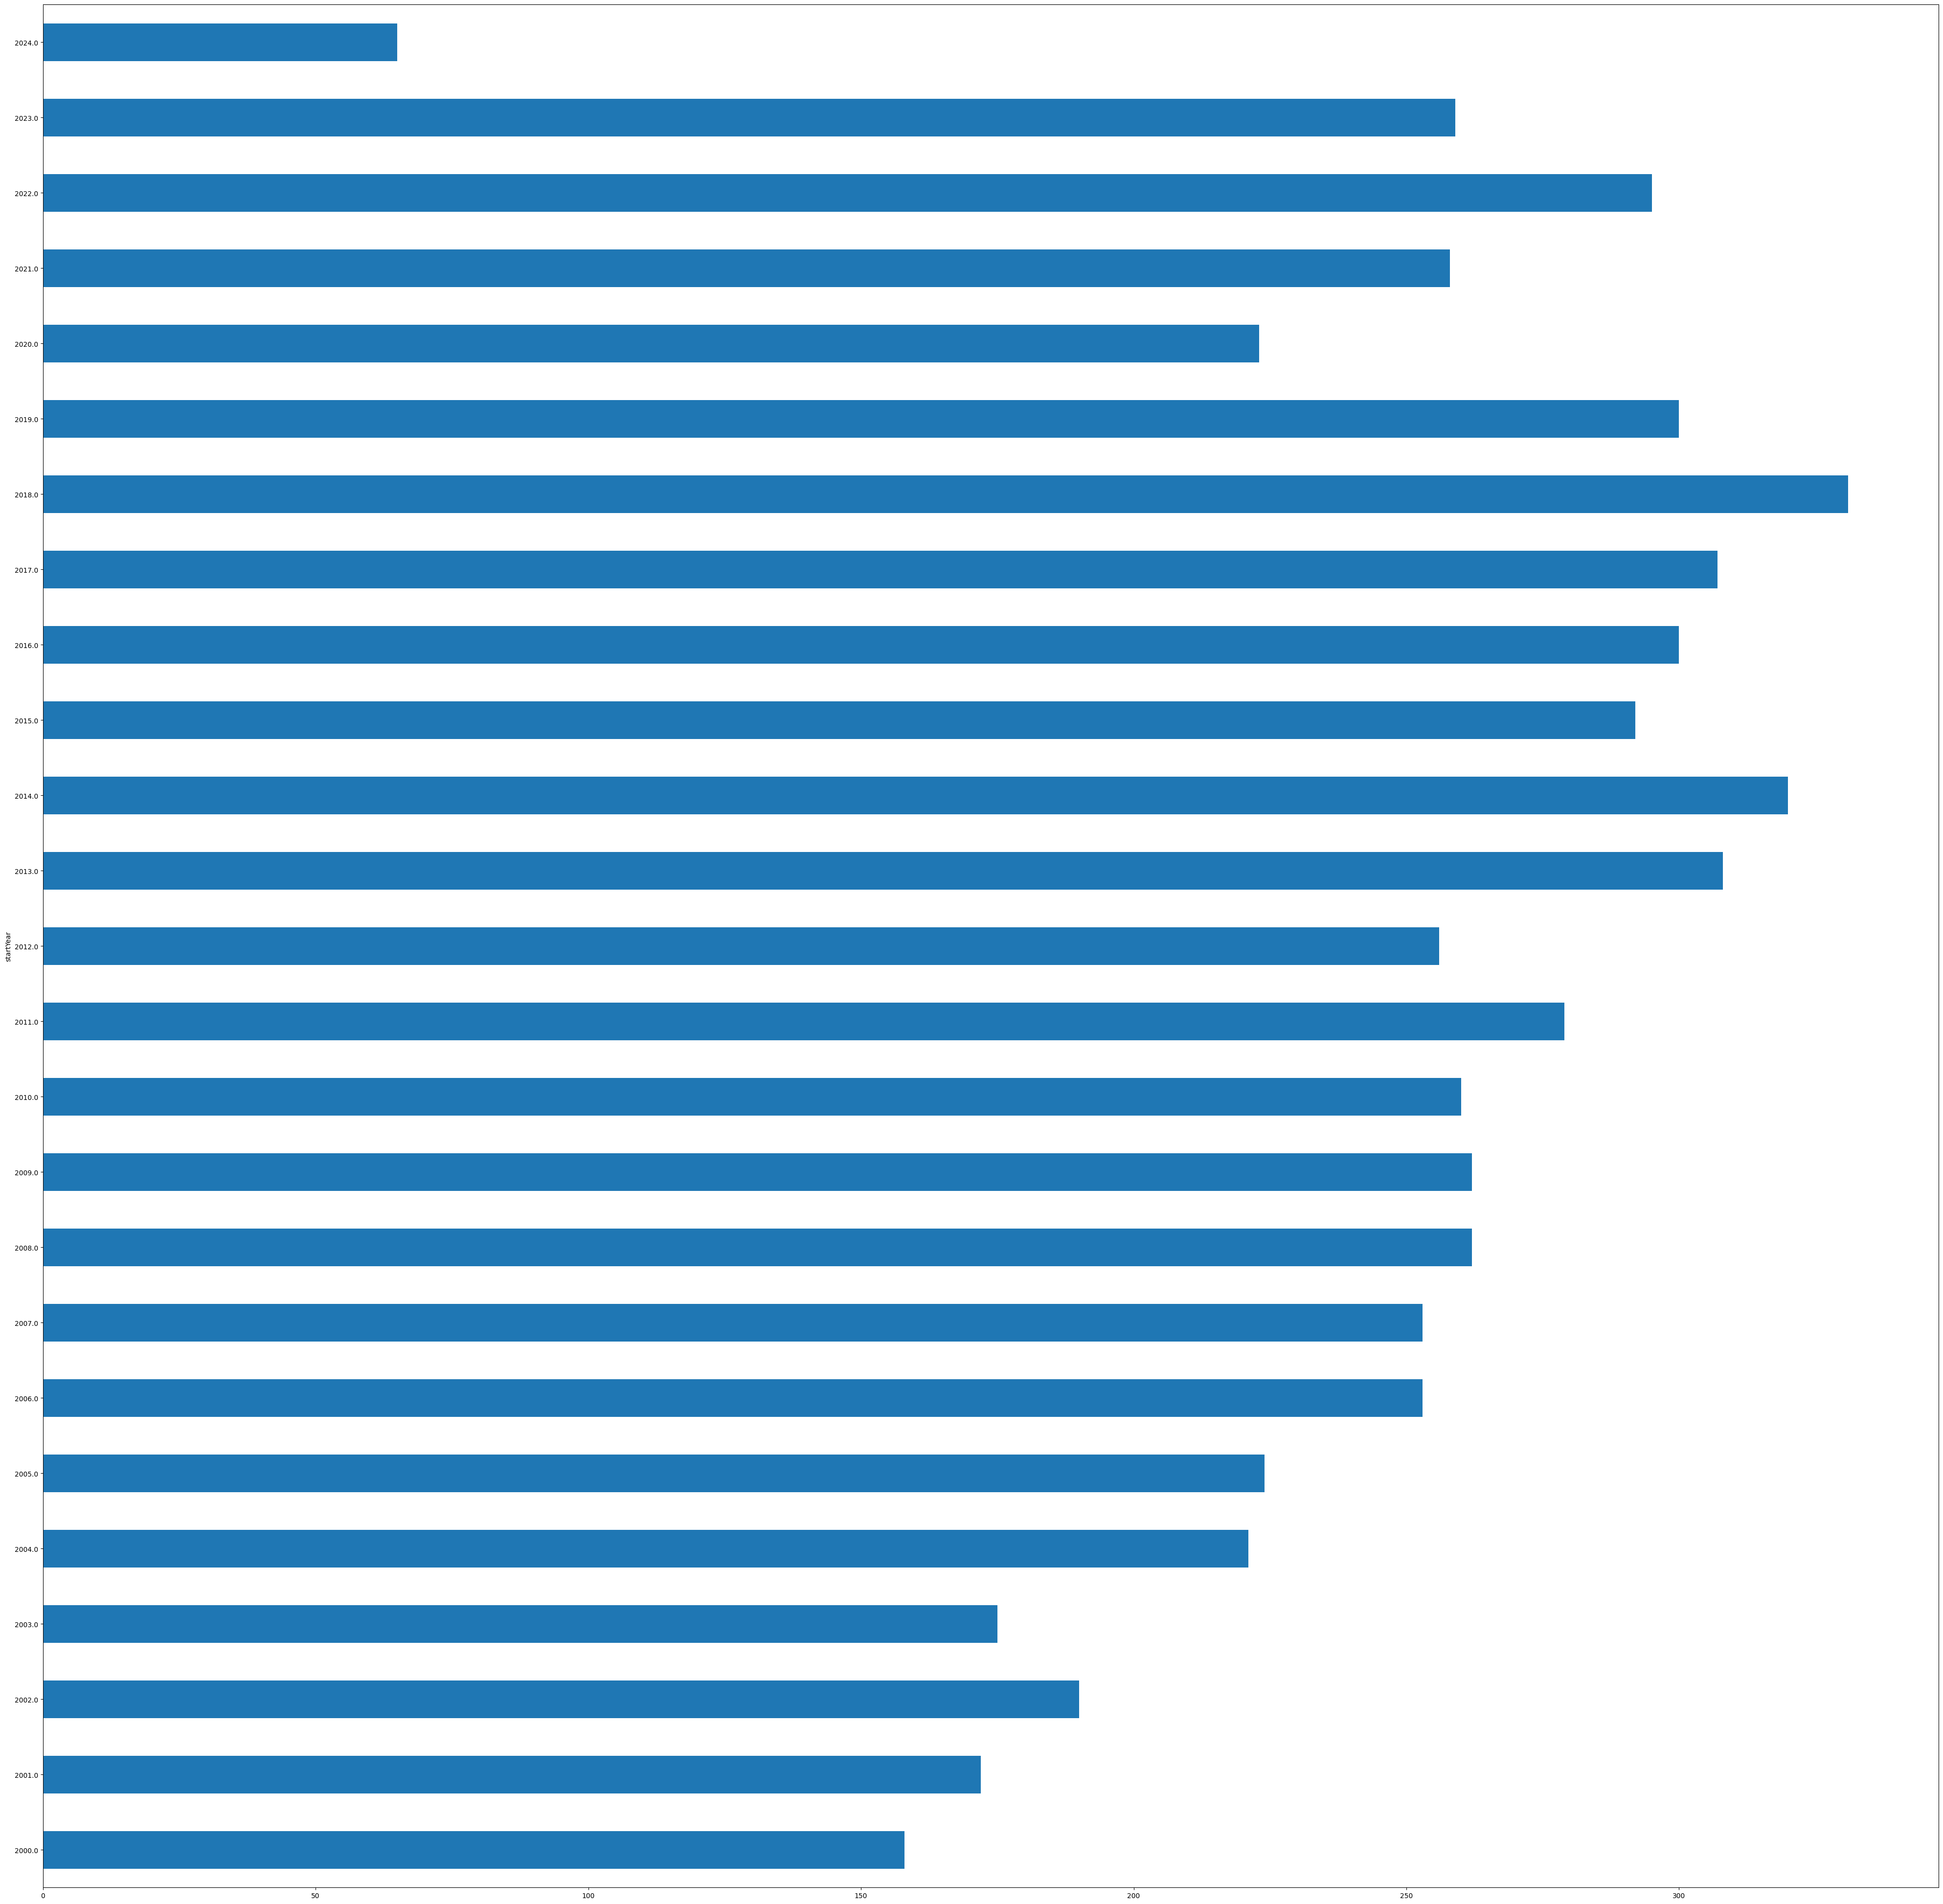

In [67]:
import matplotlib.pyplot as plt
movies_df.startYear.value_counts(dropna=False).sort_index().plot(kind='barh',figsize=(50,50))
plt.show()

In [69]:
import requests

In [70]:
def fetch_movie_data(tconst, api_key):
    try:
        response = requests.get(
            f'https://api.themoviedb.org/3/movie/{tconst}?api_key={api_key}&append_to_response=credits'
        )
        data_json = response.json()

        # Get director(s)
        directors = [member['name'] for member in data_json['credits']['crew'] if member['job'] == 'Director']

        # Get top 10 cast members
        cast = sorted(data_json['credits']['cast'], key=lambda x: x['popularity'], reverse=True)[:10]
        top_cast = [member['name'] for member in cast]

        # Get the overview
        overview = data_json.get('overview', '')

        return directors, top_cast, overview
    except Exception as e:
        return None, None, None

In [72]:
from tqdm import tqdm
movies_df['crew'] = None
movies_df['overview'] = None

api_key = 'YOUR_API_KEY_HERE'

for index, row in tqdm(movies_df.iterrows(), total=movies_df.shape[0]):
    tconst = row['tconst']
    directors, top_cast, overview = fetch_movie_data(tconst, api_key)

    if directors is not None and top_cast is not None:
        crew = ', '.join(directors + top_cast)
        movies_df.at[index, 'crew'] = crew
        movies_df.at[index, 'overview'] = overview


100%|██████████| 6223/6223 [22:45<00:00,  4.56it/s]
